### UCB–USACE LSTMs — Daily Grid‑Search + Best Model Evaluation (Calpella)

In [1]:
BASIN = "calpella"  # No need to touch this
MODE = "daily" # No need to touch this

### 0) Quick switches (edit these)

##### - `run_gridsearch`: True - perform a full grid‑search now. False - reuse the last saved best params.
##### - `skip_best_model_validation` / `skip_best_model_test`:
#####       True: reuse previously saved artifacts (requires `READ_STAMP` to match an archived run).
#####       False: re‑train the best models and regenerate metrics/plots now.
##### - `GPU_SETTING`:
#####       0: GPU - CUDA: 0 (if available)
#####      -1: default CPU

##### - `RUN_LABEL`: ties together series of runs (e.g., "BASELINE", "EXPERIMENT_X"). If you change this, you will get a new shared folder and separate hyperparams CSV.
##### - `READ_STAMP`: when *skipping* re‑runs, tells the notebook which archived stamp to read from. This is to ensure you can reproduce exact results later. ONE MORE SENTENCE WITH EXAMPLE FILEPATH

In [2]:
run_gridsearch = True  
skip_best_model_validation = False
skip_best_model_test = False
verbose = False
cross_validation = True

GPU_SETTING = -1 
NUM_ENSEMBLES = 5 

RUN_LABEL = "BASELINE" # experiment tag
READ_STAMP = "20250815T000000Z" # read artifacts stamp when skipping re-runs

#### 1) Hyperparameter space

##### - `schedule_pairs` has two tuples: (fractions, learning_rates) that is converted to a piecewise LR schedule;
##### Ex: over 48 epochs, the input ((0.5, 0.25), (0.01, 0.005, 0.001)) will lead to → 0–24: 0.01, 24–36: 0.005, 36–48: 0.001 

##### Everything else is model architectucture/training related. The notebook is equipped to handle other hyperparameters, but they have to be part of the NH library as the Config object expects them.

##### Remember that there will be `len(hyperparam_space[hp1]) * len(hyperparam_space[hp2]) * ...` total runs. So gridsearch can be computationally expensive.

In [3]:
hyperparam_space = {
    "epochs": [16, 32, 48],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

#### 2) Imports and setup

In [4]:
import sys
import pandas as pd
import os
import itertools
from pathlib import Path
from tqdm import tqdm
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\arman\Dropbox\The University\Projects\UCB-USACE-RR-PROJECT\notebooks\basins\calpella


In [6]:
# Add the repository root to sys.path (without hard-coding usernames/drives).

library_path = os.path.join('..', '..', '..','..','UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-RR-PROJECT', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\python313.zip', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\DLLs', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project', '', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\arman\\anaconda3\\envs\\ucb-usace-project\\Lib\\site-packages\\Pythonwin']


In [7]:
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (fractional_multi_lr, write_paths, to_path_or_list, ensure_output_tree, set_active_context, data_dir, repo_root, get_output_dir, make_run_stamp, get_yaml_path, ctx_for, hparams_exists, save_hparams, load_hparams, runs_latest_path, archive_runs_json, read_csv_artifact, ensure_shared_tree)
from UCB_training.UCB_plotting import (plot_timeseries_comparison, scatter_triptych_pngs_v3, ts_triptych_v3)

In [8]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-RR-PROJECT')[0] + 'UCB-USACE-RR-PROJECT'

##### 3) Stamping & run registry

##### - `RUNS_FILE`: a **LATEST** JSON file that stores the filepath for this basin/mode/label.
##### - `RUN_STAMP`: unique UTC stamp if we plan to (re)run models. It will correspond to the current UTC time when the cell is run. 
##### - `ACTIVE_STAMP`: stamp we will **write under** (if re-running) or **read from** (if skipping).

##### **Rule of thumb**
##### - If you’re skipping validation/test re-runs, set `READ_STAMP` to an archived stamp that already contains the needed artifacts.

In [9]:
RUNS_FILE = str(runs_latest_path(BASIN, MODE, RUN_LABEL)) 
SHOULD_STAMP = not (run_gridsearch or (skip_best_model_validation and skip_best_model_test))
RUN_STAMP = make_run_stamp() if SHOULD_STAMP else None
ACTIVE_STAMP = RUN_STAMP if RUN_STAMP is not None else READ_STAMP

#### 4) Activate context + ensure output tree

##### This sets up the active context used by our path router so that outputs (plots/metrics/CSVs) go into:  
##### `outputs/<BASIN>/<MODE>[/<RUN_LABEL>_<RUN_STAMP>]/{timeseries,metrics,plots,...}`

In [10]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=ACTIVE_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED_FOLDER = ensure_shared_tree(BASIN, MODE)
RUNS_PARENT = SHARED_FOLDER / "runs" / (f"{RUN_LABEL}_{RUN_STAMP}" if RUN_STAMP else RUN_LABEL)

print("NH runs will be written under:")
print(RUNS_PARENT.resolve())

NH runs will be written under:
C:\Users\arman\Dropbox\The University\Projects\UCB-USACE-RR-PROJECT\outputs\calpella\daily_shared\runs\BASELINE


#### 5) Data & feature definitions

##### - `path_to_csv`: repository data folder (daily CSVs for Calpella, etc.). The data_dir() utility finds UCB-USACE-LSTMs/russian_river_data
##### - `path_to_yaml`: base NH config (we override several inputs for this config from the notebook).
##### - `path_to_physics_data`: Where the HMS data is

In [11]:
path_to_csv = data_dir()
path_to_yaml = get_yaml_path("calpella_gage_nlayer")
path_to_physics_data = path_to_csv / "Calpella_daily_shift.csv"

#### 6) Physics‑informed feature list

##### These are **dynamic_inputs** passed when `physics_informed=True`. They augment the LSTM model with additional HMS‑derived features.
##### If you want to remove some features from the PILSTM, remove them from this list. If you want to remove features from the LSTM, remove them from the yaml file.

In [12]:
features_with_physics = [
    #from hourly
    "EF RUSSIAN 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "EF RUSSIAN 20 PRECIP-INC SCREENED",
    "POTTER VALLEY CA FLOW USGS_ADJUSTED",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    #from new capella.csv 
    'Capella Gage FLOW',
    'EF Russian 20 ET-POTENTIAL',
    'EF Russian 20 FLOW',
    'EF Russian 20 FLOW-BASE',
    'EF Russian 20 INFILTRATION',
    'EF Russian 20 PERC-SOIL',
    'EF Russian 20 SATURATION FRACTION',
    #    'Lake Mendocino Storage',
]

In [13]:
no_physics_results = []
physics_results = []

In [14]:
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-10-15 21:38:46


C:\Users\arman\AppData\Local\Temp\ipykernel_11860\2469064542.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


#### 7) Grid‑search: run or reuse

##### - If `run_gridsearch=True` (or no best‑params cached yet), we iterate all combinations, train, evaluate on **validation**, and collect metrics into the following dataframes:
#####   `*_no_physics_gridsearch.csv` and `*_physics_gridsearch.csv`.
##### - We then save a **best‑params CSV** plus the full grid results into:
#####   `outputs/<basin>/<mode>_shared/hyperparams/`.
##### If `run_gridsearch=False` and best params CSV exists, we **skip** to loading them.

In [ ]:
hyperparam_names = []
for i, hp in enumerate(hyperparam_space.keys()):
    hyperparam_names.append(hp)

total_iters = 1
for name in hyperparam_names:
    total_iters *= len(hyperparam_space[name])

if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val
                
            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})

        if verbose:
            print(f"\nNoPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        if not cross_validation:
            trainer.train()
            csv_path, metrics_dict = trainer.results()
        else:
            metrics_dict = trainer.cross_validate(run_path=RUNS_PARENT)
        
        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        row_data["learning_rate"] = str(hp_run["learning_rate"])
            
        for k, v in metrics_dict.items():
            row_data[k] = v
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Grid-Search:  33%|###6       | 1/3 [01:41<03:23, 101.94s/it]

Fold 1 results
{'NSE': 0.35104620456695557, 'MSE': 228052.921875, 'RMSE': np.float64(477.548868572631), 'KGE': np.float64(0.29204577506832696), 'Alpha-NSE': 0.39028344101419027, 'Beta-KGE': 0.9316874146461487, 'Beta-NSE': -0.03836938122091569, 'Pearson-r': 0.6467602849006653, 'FHV': np.float32(-71.180626), 'FMS': np.float32(32.37127), 'FLV': np.float32(24.50163), 'Peak-Timing': np.float64(0.0), 'Peak-MAPE': np.float32(81.54516)}


Fold 2 results
{'NSE': 0.6129441857337952, 'MSE': 36344.79296875, 'RMSE': np.float64(190.64310364854535), 'KGE': np.float64(0.7962671943603324), 'Alpha-NSE': 0.9780239665393441, 'Beta-KGE': 1.0510951280593872, 'Beta-NSE': 0.05657002383986083, 'Pearson-r': 0.8040066361427307, 'FHV': np.float32(-20.455347), 'FMS': np.float32(55.742626), 'FLV': np.float32(-811.06946), 'Peak-Timing': np.float64(0.0), 'Peak-MAPE': np.float32(33.48046)}


Fold 3 results
{'NSE': 0.4789993166923523, 'MSE': 21162.318359375, 'RMSE': np.float64(145.4727409495504), 'KGE': np.float64(0.42

Grid-Search:  67%|#######3   | 2/3 [05:11<02:45, 165.38s/it]

Fold 1 results
{'NSE': 0.5117800235748291, 'MSE': 171568.4375, 'RMSE': np.float64(414.2082054957386), 'KGE': np.float64(0.40258033891126344), 'Alpha-NSE': 0.4434549117492649, 'Beta-KGE': 0.9118066430091858, 'Beta-NSE': -0.04953587115651104, 'Pearson-r': 0.8015314936637878, 'FHV': np.float32(-60.2027), 'FMS': np.float32(-6.1420026), 'FLV': np.float32(-34.693077), 'Peak-Timing': np.float64(1.0), 'Peak-MAPE': np.float32(73.90106)}


Fold 2 results
{'NSE': 0.6637942790985107, 'MSE': 31569.93359375, 'RMSE': np.float64(177.6792998459584), 'KGE': np.float64(0.8292113561847648), 'Alpha-NSE': 0.9921604722001409, 'Beta-KGE': 1.0227928161621094, 'Beta-NSE': 0.025235117116876666, 'Pearson-r': 0.8309207558631897, 'FHV': np.float32(-9.874884), 'FMS': np.float32(59.40003), 'FLV': np.float32(-417.56), 'Peak-Timing': np.float64(0.0), 'Peak-MAPE': np.float32(21.888586)}


Fold 3 results
{'NSE': 0.538410484790802, 'MSE': 18749.119140625, 'RMSE': np.float64(136.92742289484966), 'KGE': np.float64(0.5202685

In [ ]:
if run_gridsearch or not hparams_exists(BASIN, MODE, RUN_LABEL):   
    for combinations in tqdm(
        itertools.product(*[hyperparam_space[hp] for hp in hyperparam_names]), 
        desc="Grid-Search", 
        total=total_iters, 
        unit="it", 
        ncols=60, 
        ascii=True):

        hp_run = {}
        j = 0
        schedule_pairs = None
        
        while j < len(hyperparam_names):
            name = hyperparam_names[j]
            val  = combinations[j]

            if name == "seq_length":
                hp_run["seq_length"] = val

            elif name == "schedule_pairs":
                schedule_pairs = val

            else:
                hp_run[name] = val

            j += 1

        if schedule_pairs is not None:
            fractions, rates = schedule_pairs
            hp_run["learning_rate"] = fractional_multi_lr(
                epochs=int(hp_run["epochs"]), fractions=list(fractions), lrs=list(rates))
        else:
            hp_run.setdefault("learning_rate", {0: 0.01, 30: 0.005, 40: 0.001})
            
        if verbose:
            print(f"\nPhysics: {hp_run}")
            
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp_run,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING,
            verbose=verbose,
            runs_parent=RUNS_PARENT,
            run_label=RUN_LABEL,
            run_stamp=RUN_STAMP)
        
        if not cross_validation:
            trainer.train()
        else:
            trainer.cross_validate(run_path=RUNS_PARENT)
        csv_path, metrics_dict = trainer.results()

        row_data = {}
        j = 0
        while j < len(hyperparam_names):
            row_data[hyperparam_names[j]] = combinations[j]
            j += 1

        row_data["learning_rate"] = str(hp_run["learning_rate"])

        for k, v in metrics_dict.items():
            row_data[k] = v
            
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    save_hparams(best_df=best_params_df, basin=BASIN, mode=MODE, label=RUN_LABEL, run_stamp=RUN_STAMP, df_no=df_no_physics, df_phys=df_physics)
else:
    print("Skipping grid search!")

Grid-Search:  33%|####        | 1/3 [00:46<01:32, 46.12s/it]

C:\Users\arman\Dropbox\The University\Projects\UCB-USACE-RR-PROJECT\outputs\calpella\daily_shared\runs\BASELINE\testing_run_0610_134945


Grid-Search:  67%|########    | 2/3 [02:05<01:05, 65.75s/it]

C:\Users\arman\Dropbox\The University\Projects\UCB-USACE-RR-PROJECT\outputs\calpella\daily_shared\runs\BASELINE\testing_run_0610_135031


Grid-Search:  67%|########    | 2/3 [02:49<01:24, 84.72s/it]


KeyboardInterrupt: 

: 

#### 8) Load best hyperparameters (if not just saved)

##### The file containing each hyperparameter combination's performance lives in:
##### `outputs/<basin>/<mode>_shared/hyperparams/<basin>_<mode>_<RUN_LABEL>_hyperparams.csv`

In [ ]:
try:
    if run_gridsearch:
        print("\n[INFO] Using best_params_df from the just-completed grid search (ignoring READ_STAMP).")
    else:
        print("\nLoading best hyperparams from CSV...")
        best_params_df = load_hparams(BASIN, MODE, RUN_LABEL, stamp=READ_STAMP)
except FileNotFoundError as e:
    raise SystemExit(f"[ERROR] {e}  (Set run_gridsearch=True to generate it.)")

best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

best_no_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_no_physics_params[name] = float(best_no_phys[name])
        j += 1

    elif name == "seq_length":
        best_no_physics_params["seq_length"] = int(best_no_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_no_physics_params[name] = int(best_no_phys[name])
        j += 1

if "learning_rate" in best_no_phys and pd.notna(best_no_phys["learning_rate"]):
    best_no_physics_params["learning_rate"] = eval(str(best_no_phys["learning_rate"]))

elif "schedule_pairs" in best_no_phys and pd.notna(best_no_phys["schedule_pairs"]):
    sp = best_no_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_no_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_no_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_no_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

best_physics_params = {}
j = 0
while j < len(hyperparam_names):
    name = hyperparam_names[j]
    if name == "output_dropout":
        best_physics_params[name] = float(best_phys[name])
        j += 1

    elif name == "seq_length":
        best_physics_params["seq_length"] = int(best_phys["seq_length"])
        j += 1

    elif name == "schedule_pairs":
        j += 1

    else:
        best_physics_params[name] = int(best_phys[name])
        j += 1

if "learning_rate" in best_phys and pd.notna(best_phys["learning_rate"]):
    best_physics_params["learning_rate"] = eval(str(best_phys["learning_rate"]))

elif "schedule_pairs" in best_phys and pd.notna(best_phys["schedule_pairs"]):
    sp = best_phys["schedule_pairs"]
    if isinstance(sp, str):
        sp = eval(sp)
    fractions, rates = sp
    best_physics_params["learning_rate"] = fractional_multi_lr(
        epochs=int(best_physics_params["epochs"]),
        fractions=list(fractions),
        lrs=list(rates))

else:
    best_physics_params["learning_rate"] = {0: 0.01, 30: 0.005, 40: 0.001}

print("Loaded best hyperparams from CSV:")
print("Best NO-PHYS:", best_no_physics_params)
print("Best PHYS:", best_physics_params)


Loading best hyperparams from CSV...
C:\Users\arman\Dropbox\The University\Projects\UCB-USACE-RR-PROJECT\outputs\calpella\daily_shared\hyperparams\archive\calpella_daily_BASELINE_hyperparams_20250815T000000Z.csv
Loaded best hyperparams from CSV:
Best NO-PHYS: {'hidden_size': 256, 'learning_rate': {0: 0.01, 16: 0.005, 24: 0.001}}
Best PHYS: {'hidden_size': 256, 'learning_rate': {0: 0.01, 8: 0.005, 12: 0.001}}


: 

#### 9a) Re-run validation period with best hyperparameters

In [ ]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

: 

In [ ]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)

    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

: 

HMS
  NSE = 0.749
  PBIAS = -4.556
LSTM
  NSE = 0.783
  PBIAS = 6.159
PILSTM
  NSE = 0.835
  PBIAS = 0.057


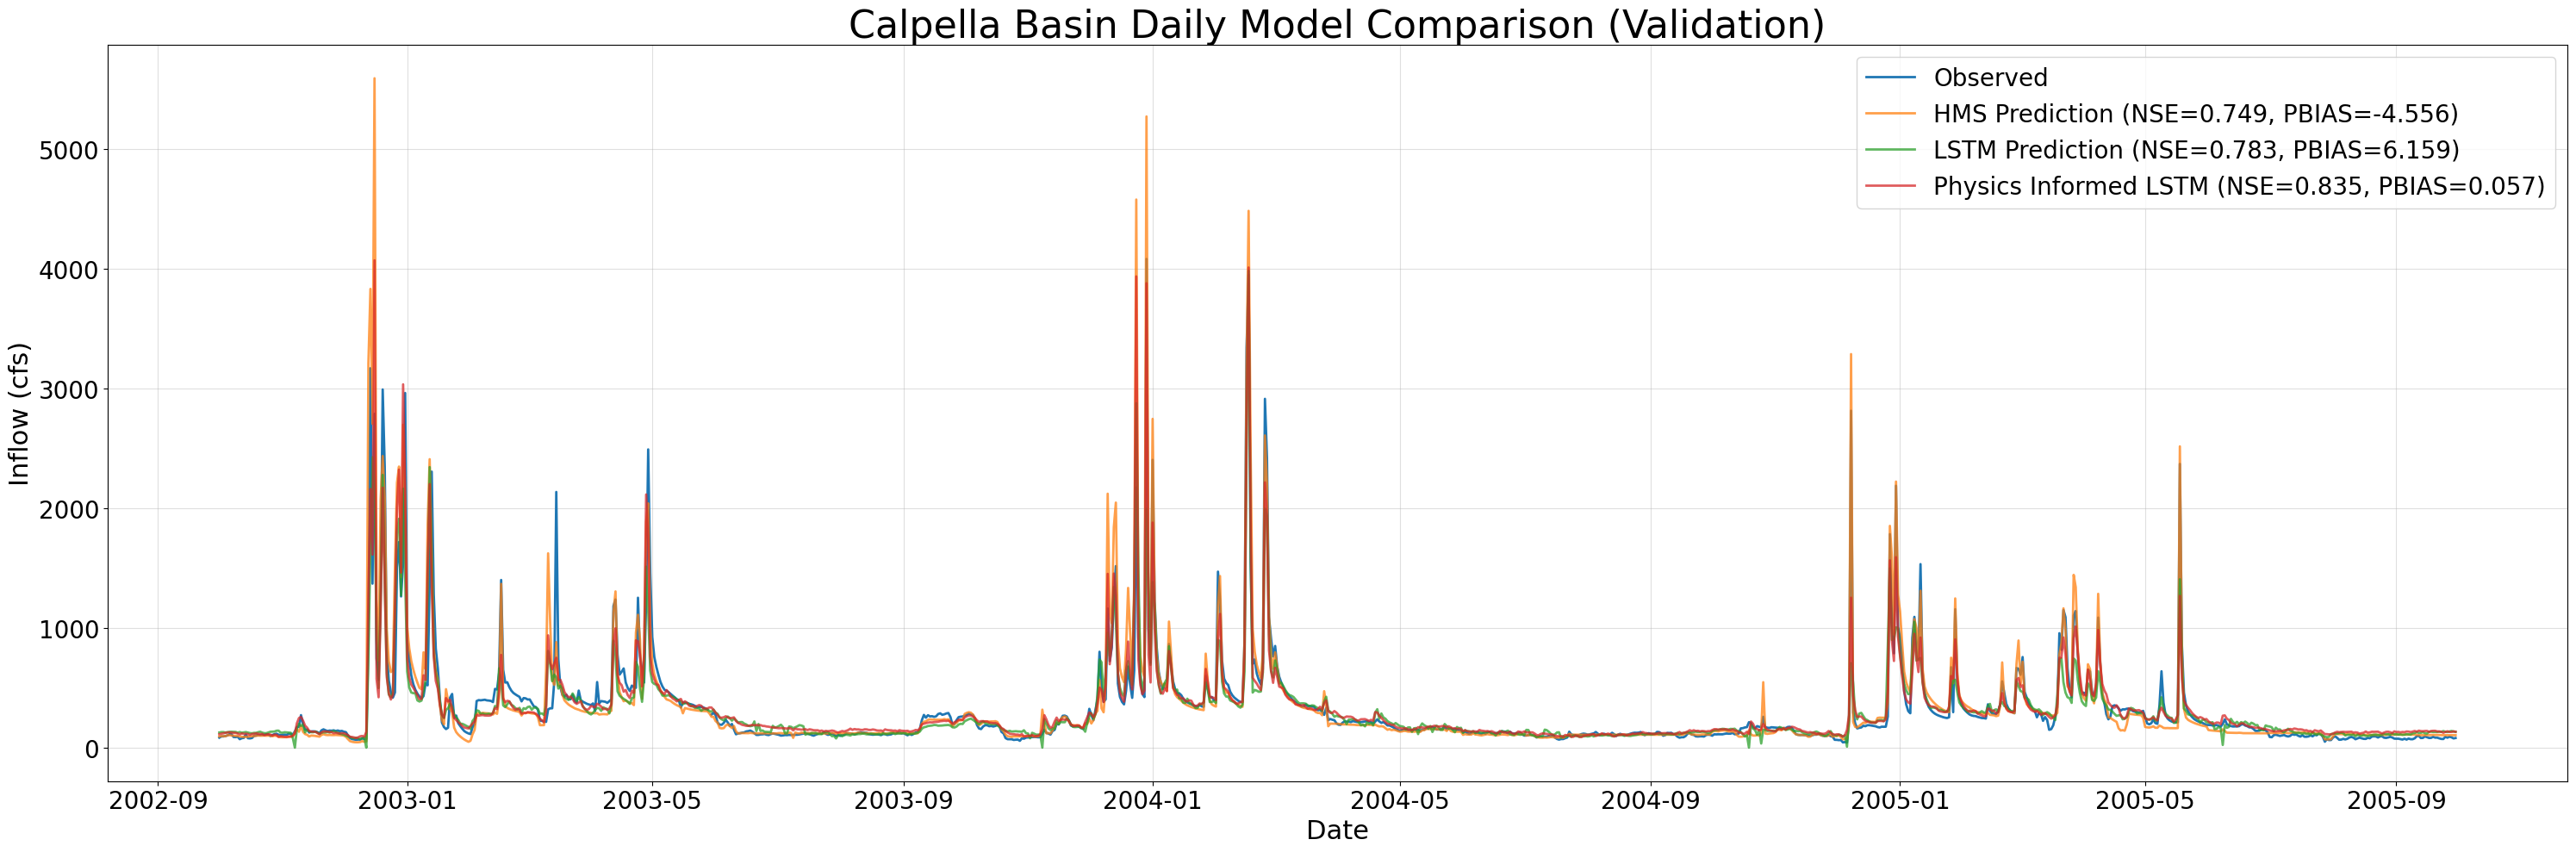

: 

In [ ]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df_val = read_csv_artifact("calpella_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Basin Daily Model Comparison (Validation)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)

In [ ]:
if skip_best_model_validation:
    val_metrics = read_csv_artifact("calpella_daily_val_metrics.csv", kind="metrics", period="validation", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
    print(val_metrics)

                      HMS          LSTM        PILSTM
NSE              0.749142      0.782530      0.835123
MSE          42975.101681  37255.325250  28245.476669
RMSE           207.304370    193.016386    168.063907
KGE              0.757372      0.748981      0.880284
Alpha-NSE        1.223944      0.781527      0.916869
Beta-KGE         1.045560      0.938408      0.999434
Beta-NSE         0.034856     -0.047121     -0.000433
Pearson-r        0.918504      0.892826      0.913856
FHV             19.067591    -22.076189     -6.914006
FMS             -9.037004    -14.040710    -17.915721
FLV             -1.647186  -2241.225409     48.506208
Peak-Timing      0.000000      0.400000      0.200000
Peak-MAPE       18.226079     53.579921     33.819286
PBIAS           -4.555977      6.159203      0.056585


: 

#### 9b) Re-run test period with best hyperparameters

In [ ]:
if not skip_best_model_test:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

: 

In [ ]:
if not skip_best_model_test:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        num_ensemble_members = NUM_ENSEMBLES,
        verbose=verbose,
        runs_parent=RUNS_PARENT,
        run_label=RUN_LABEL,
        run_stamp=RUN_STAMP)
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

: 

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.802
  PBIAS = 7.954
PILSTM
  NSE = 0.841
  PBIAS = 7.626


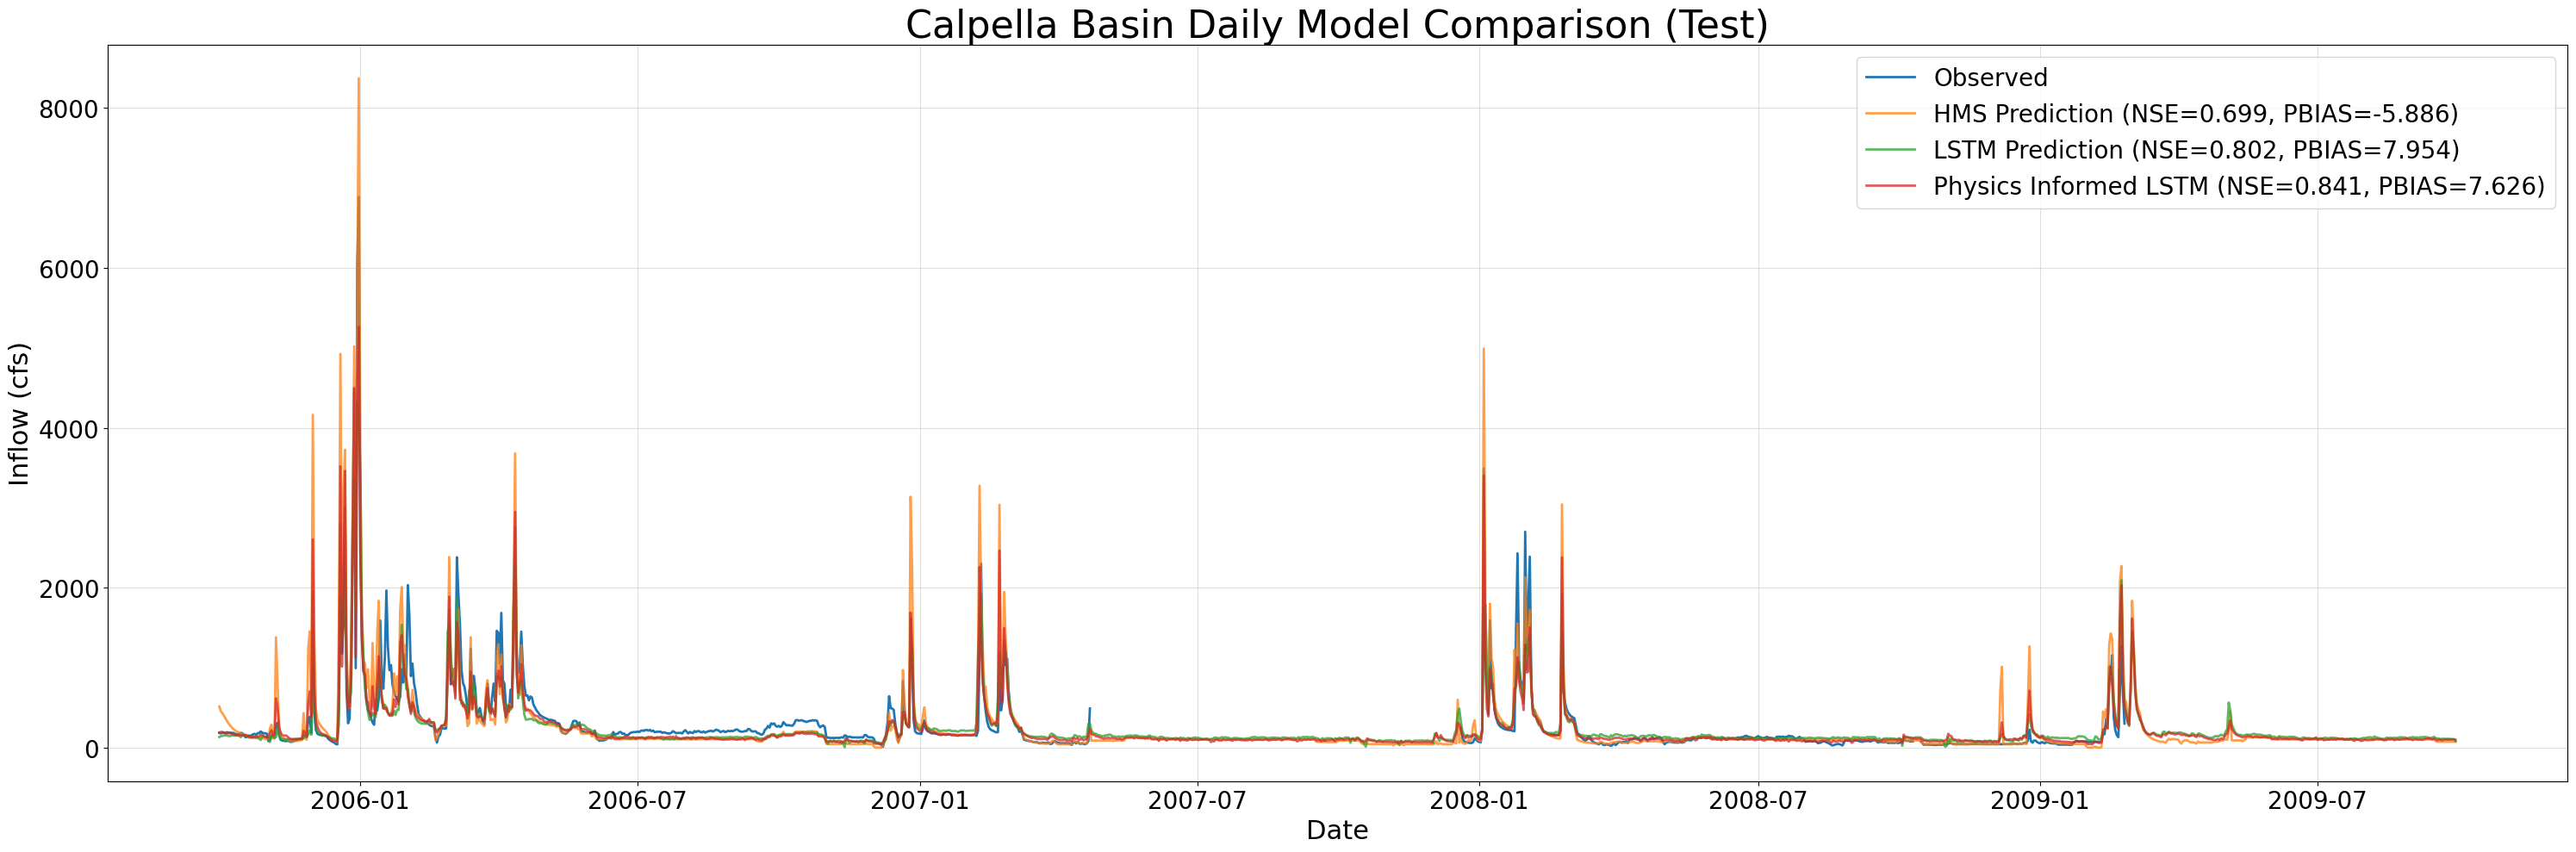

: 

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    combined_df = read_csv_artifact("calpella_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)
    plot_timeseries_comparison(source=combined_df, title="Calpella Basin Daily Model Comparison (Test)", backend="mpl", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Basin Daily Model Comparison (Test)", backend="plotly", metrics=["NSE", "PBIAS"], metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=12, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.802
  PBIAS = 7.954
PILSTM
  NSE = 0.841
  PBIAS = 7.626


: 

In [ ]:
test_metrics = read_csv_artifact("calpella_daily_test_metrics.csv", kind="metrics", period="test", index_col=0, stamp = READ_STAMP, run_label = RUN_LABEL)
print(test_metrics)

                      HMS          LSTM        PILSTM
NSE              0.699185      0.802015      0.841130
MSE          76611.391217  50422.880093  40461.058142
RMSE           276.787628    224.550395    201.149343
KGE              0.746423      0.723396      0.833223
Alpha-NSE        1.224704      0.750466      0.875577
Beta-KGE         1.058860      0.920459      0.923743
Beta-NSE         0.034578     -0.046727     -0.044797
Pearson-r        0.898291      0.911032      0.919263
FHV             25.593699    -23.217692     -7.035259
FMS              0.630349    -29.641381    -12.443531
FLV           -969.540579    -78.329529     54.654418
Peak-Timing      0.000000      0.750000      0.000000
Peak-MAPE       54.234115     40.796099     19.513621
PBIAS           -5.886041      7.954121      7.625681


: 

In [ ]:
if not skip_best_model_test:
    write_paths("no_physics", lstmNoPhysicsExtBest, filename = RUNS_FILE)
    write_paths("physics", lstmPhysicsExtBest, filename = RUNS_FILE)
    archived_path = archive_runs_json(Path(RUNS_FILE), BASIN, MODE, RUN_LABEL, RUN_STAMP)

: 

In [ ]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-10-02 17:44:25
Total time: 0:00:16.138225


C:\Users\arman\AppData\Local\Temp\ipykernel_15784\3925244319.py:1: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



: 

#### 10) Additional plots (Validation/Test; whole, wettest, driest water‑years); timeseries + scatter triptychs
##### We reuse either the freshly generated combined timeseries or the archived CSVs (depending on skip flags).
##### Note: For more detail, all these functions are in **`UCB_training/UCB_plotting.py`**

In [ ]:
if skip_best_model_validation:
    combined_df_val = read_csv_artifact("calpella_daily_val_combined_ts.csv", kind="csv", period="validation", stamp = READ_STAMP, run_label = RUN_LABEL)
if skip_best_model_test:
    combined_df = read_csv_artifact("calpella_daily_test_combined_ts.csv", kind="csv", period="test", stamp = READ_STAMP, run_label = RUN_LABEL)

: 

In [ ]:
metric_list = ["NSE", "PBIAS"]

wettest_start_val = "2003-10-01"
wettest_end_val = "2004-09-30"
dryest_start_val = "2004-10-01"
dryest_end_val = "2005-09-30"
wettest_start_test = "2005-10-01"
wettest_end_test = "2006-09-30"
dryest_start_test = "2008-10-01"
dryest_end_test = "2009-09-30"

: 

HMS
  NSE = 0.749
  PBIAS = -4.556
LSTM
  NSE = 0.783
  PBIAS = 6.159
PILSTM
  NSE = 0.835
  PBIAS = 0.057


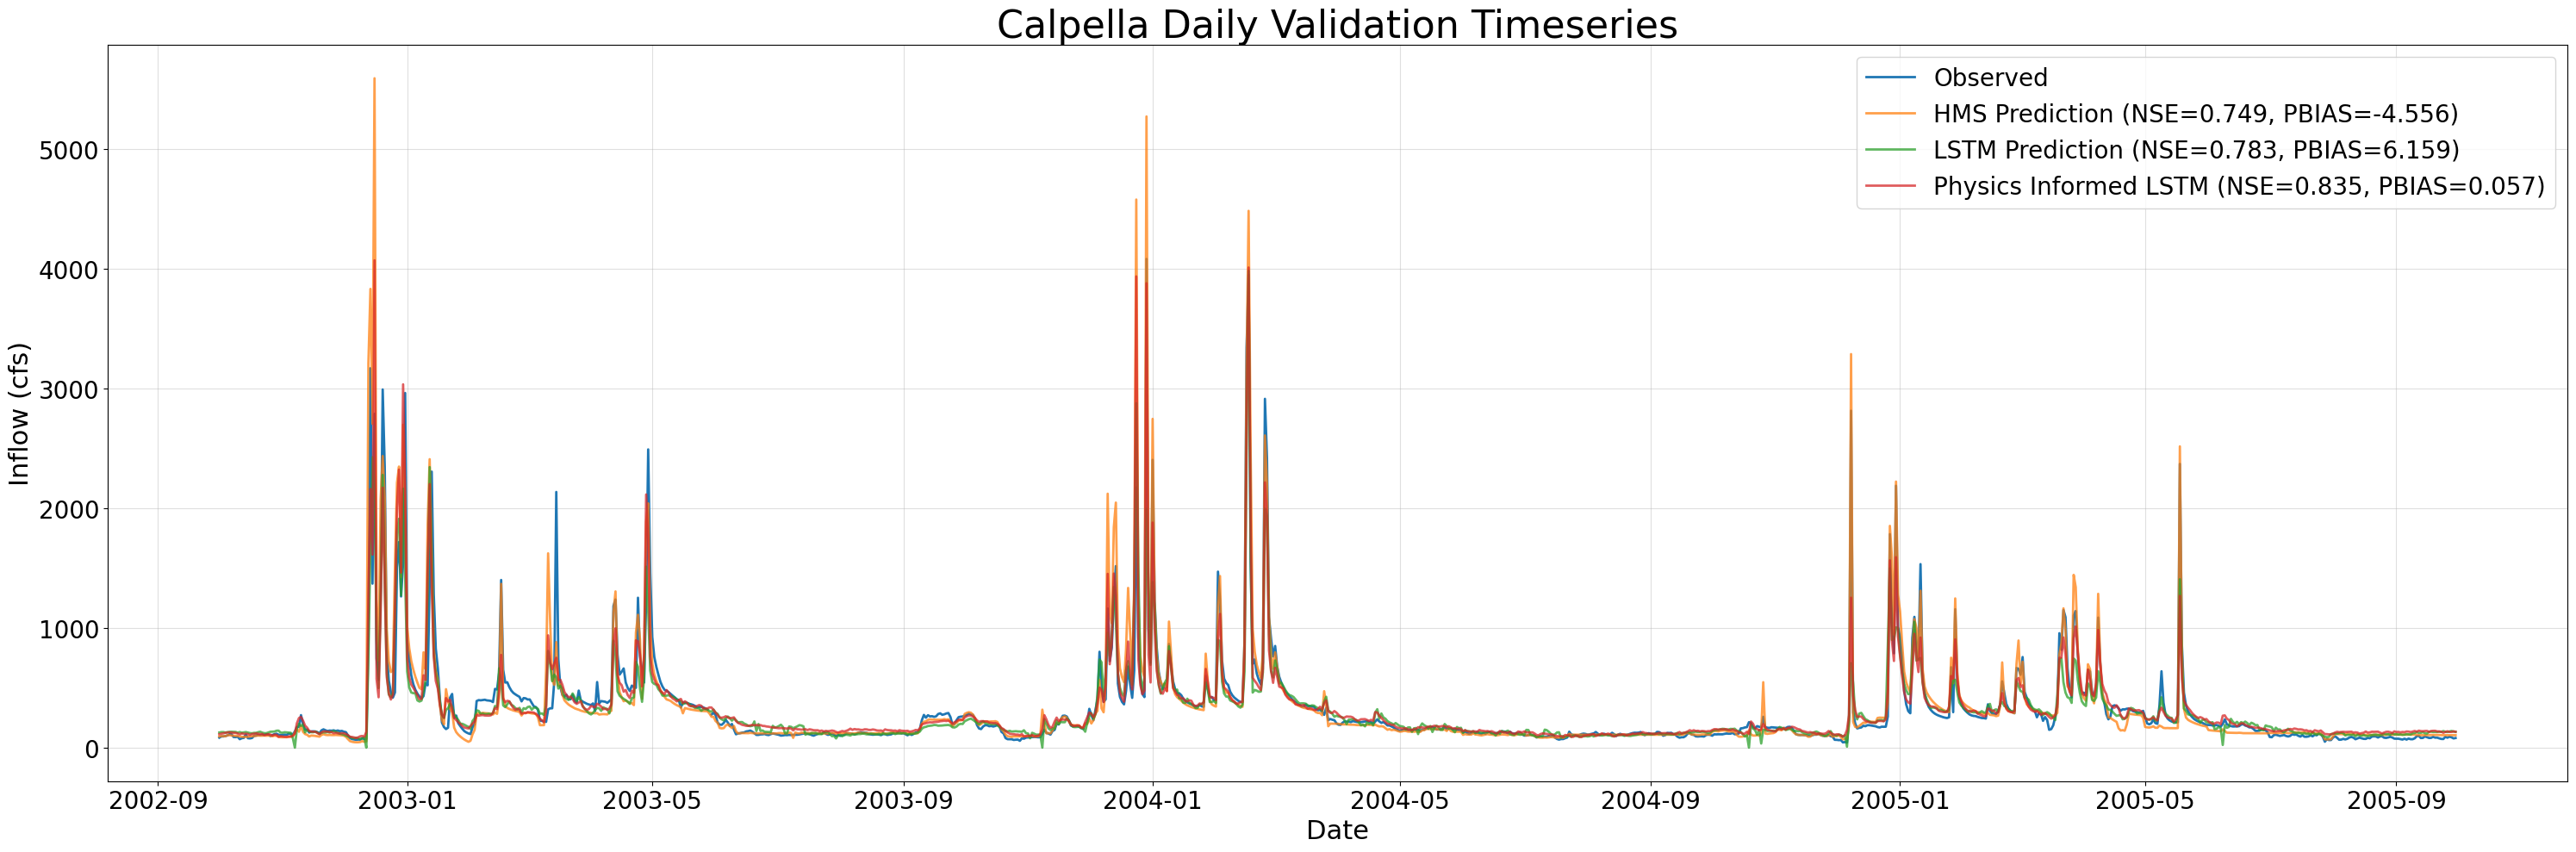

: 

In [ ]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Validation Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Validation Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_val_metrics.csv", ts_out="calpella_daily_val_combined_ts.csv", fig_out="calpella_daily_val_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.802
  PBIAS = 7.954
PILSTM
  NSE = 0.841
  PBIAS = 7.626


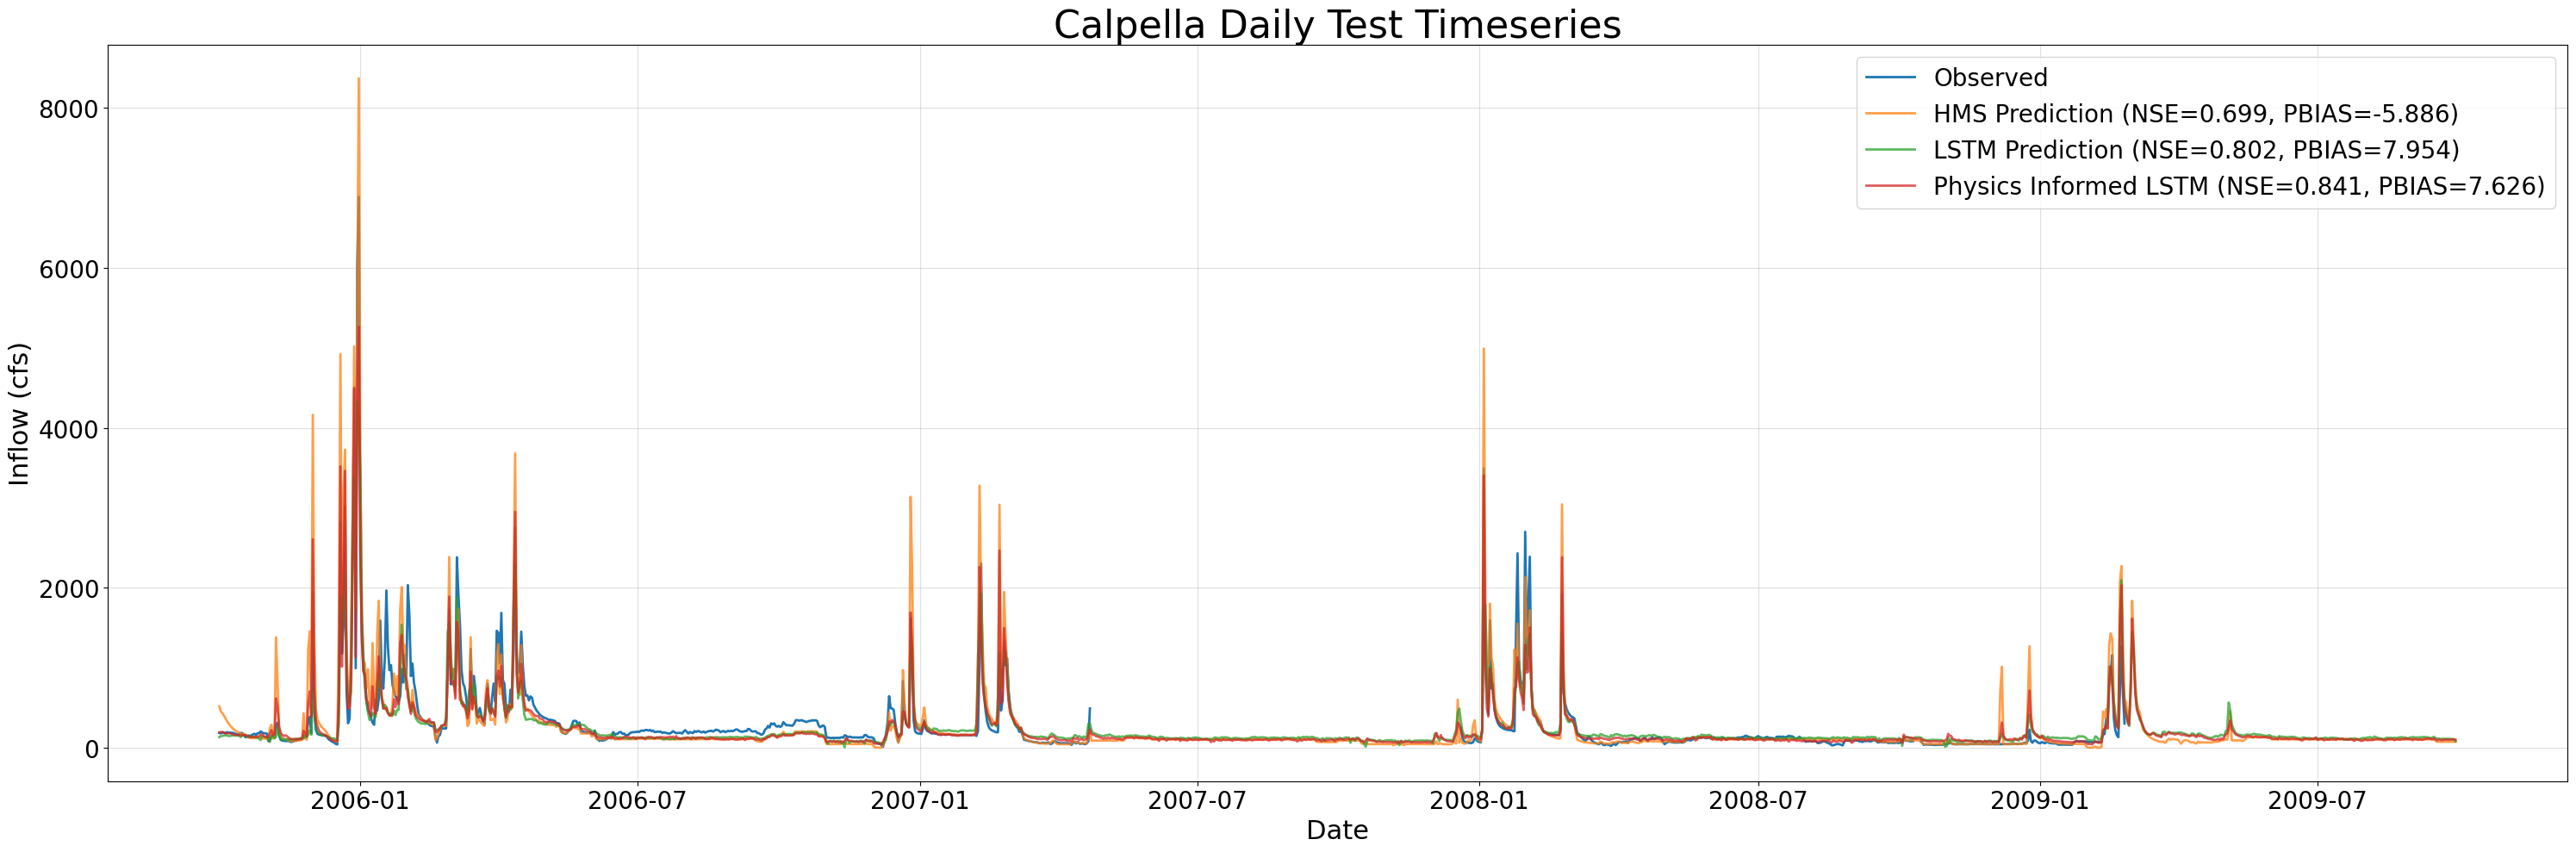

: 

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Test Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Test Timeseries", backend="mpl", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", fig_out="calpella_daily_test_model_comparison.png", legend_font=20, axis_font=22)

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Test Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Timeseries – Interactive", backend="plotly", metrics=metric_list, metrics_out="calpella_daily_test_metrics.csv", ts_out="calpella_daily_test_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.699
  PBIAS = -5.886
LSTM
  NSE = 0.802
  PBIAS = 7.954
PILSTM
  NSE = 0.841
  PBIAS = 7.626


: 

### Wettest Year Performance

HMS
  NSE = 0.833
  PBIAS = -8.424
LSTM
  NSE = 0.868
  PBIAS = 2.772
PILSTM
  NSE = 0.915
  PBIAS = -0.895


KeyboardInterrupt: 

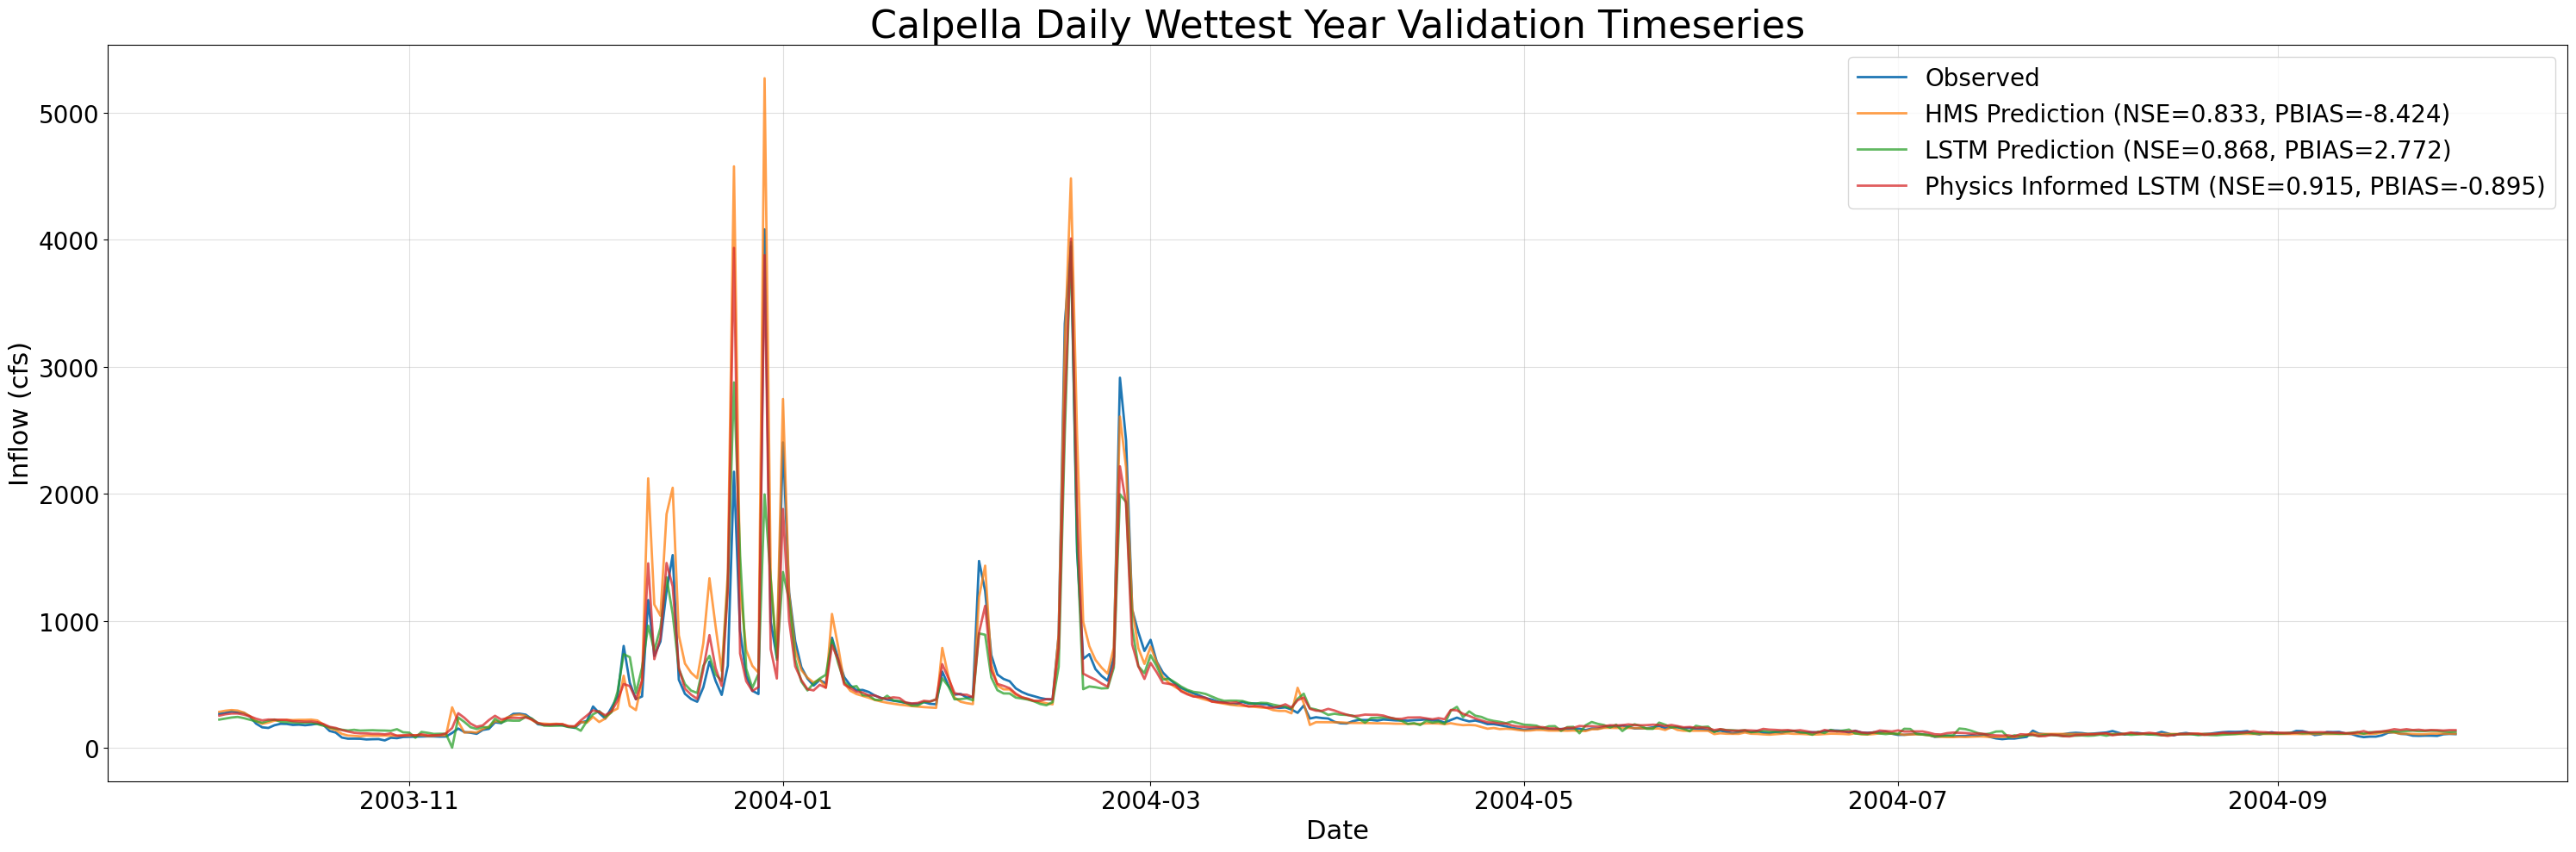

: 

In [ ]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="calpella_daily_val_wet_metrics.csv", ts_out="calpella_daily_val_wet_combined_ts.csv", fig_out="calpella_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Wettest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_val, end_date=wettest_end_val, metrics_out="calpella_daily_val_wet_metrics.csv", ts_out="calpella_daily_val_wet_combined_ts.csv", fig_out="calpella_daily_val_wet_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = 0.736
  PBIAS = -0.531
LSTM
  NSE = 0.802
  PBIAS = 20.627
PILSTM
  NSE = 0.860
  PBIAS = 14.597


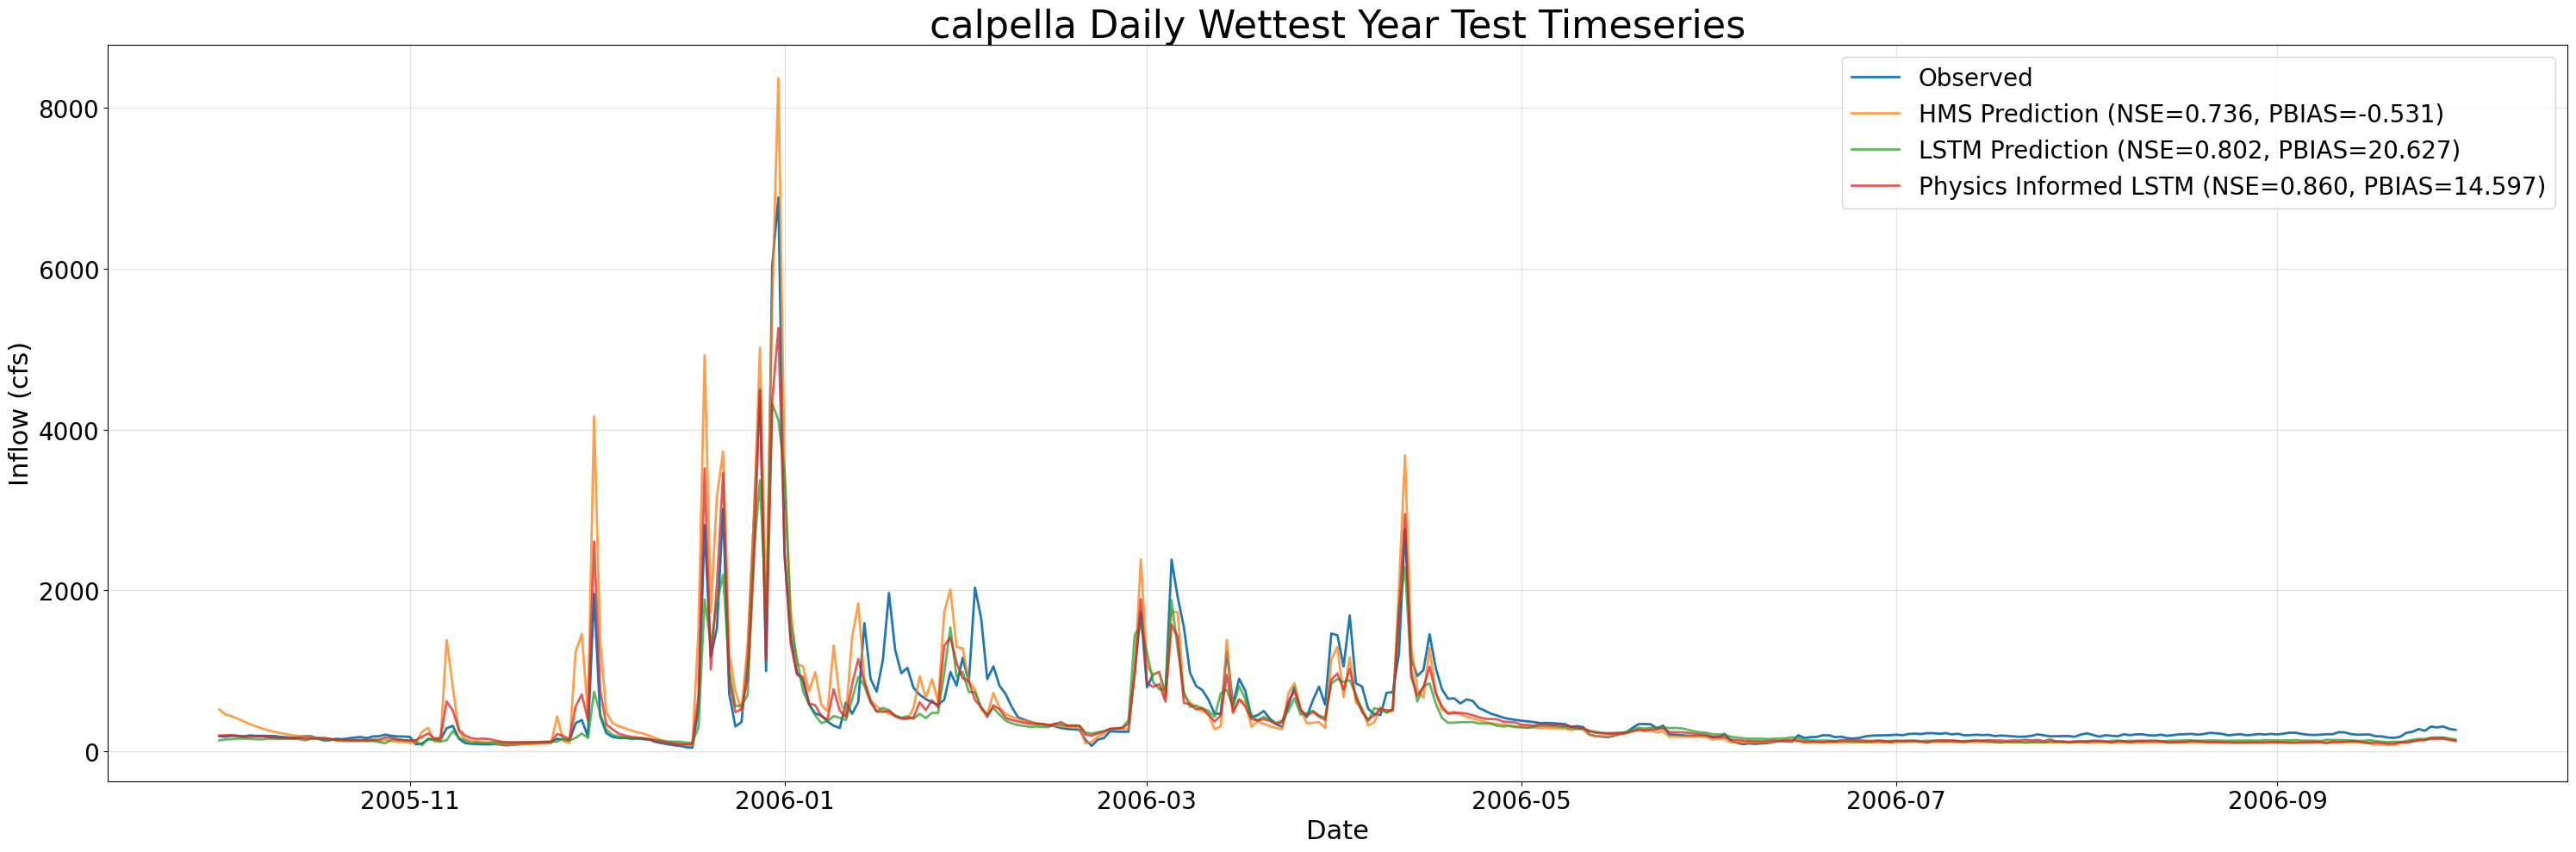

: 

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="calpella Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", fig_out="calpella_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="calpella Daily Wettest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", fig_out="calpella_daily_test_wet_model_comparison.png", legend_font=20, axis_font=22)

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Wettest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=wettest_start_test, end_date=wettest_end_test, metrics_out="calpella_daily_test_wet_metrics.csv", ts_out="calpella_daily_test_wet_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = 0.736
  PBIAS = -0.531
LSTM
  NSE = 0.802
  PBIAS = 20.627
PILSTM
  NSE = 0.860
  PBIAS = 14.597


: 

##### Dryest Year Performance

HMS
  NSE = 0.931
  PBIAS = -2.703
LSTM
  NSE = 0.694
  PBIAS = 5.178
PILSTM
  NSE = 0.831
  PBIAS = -1.209


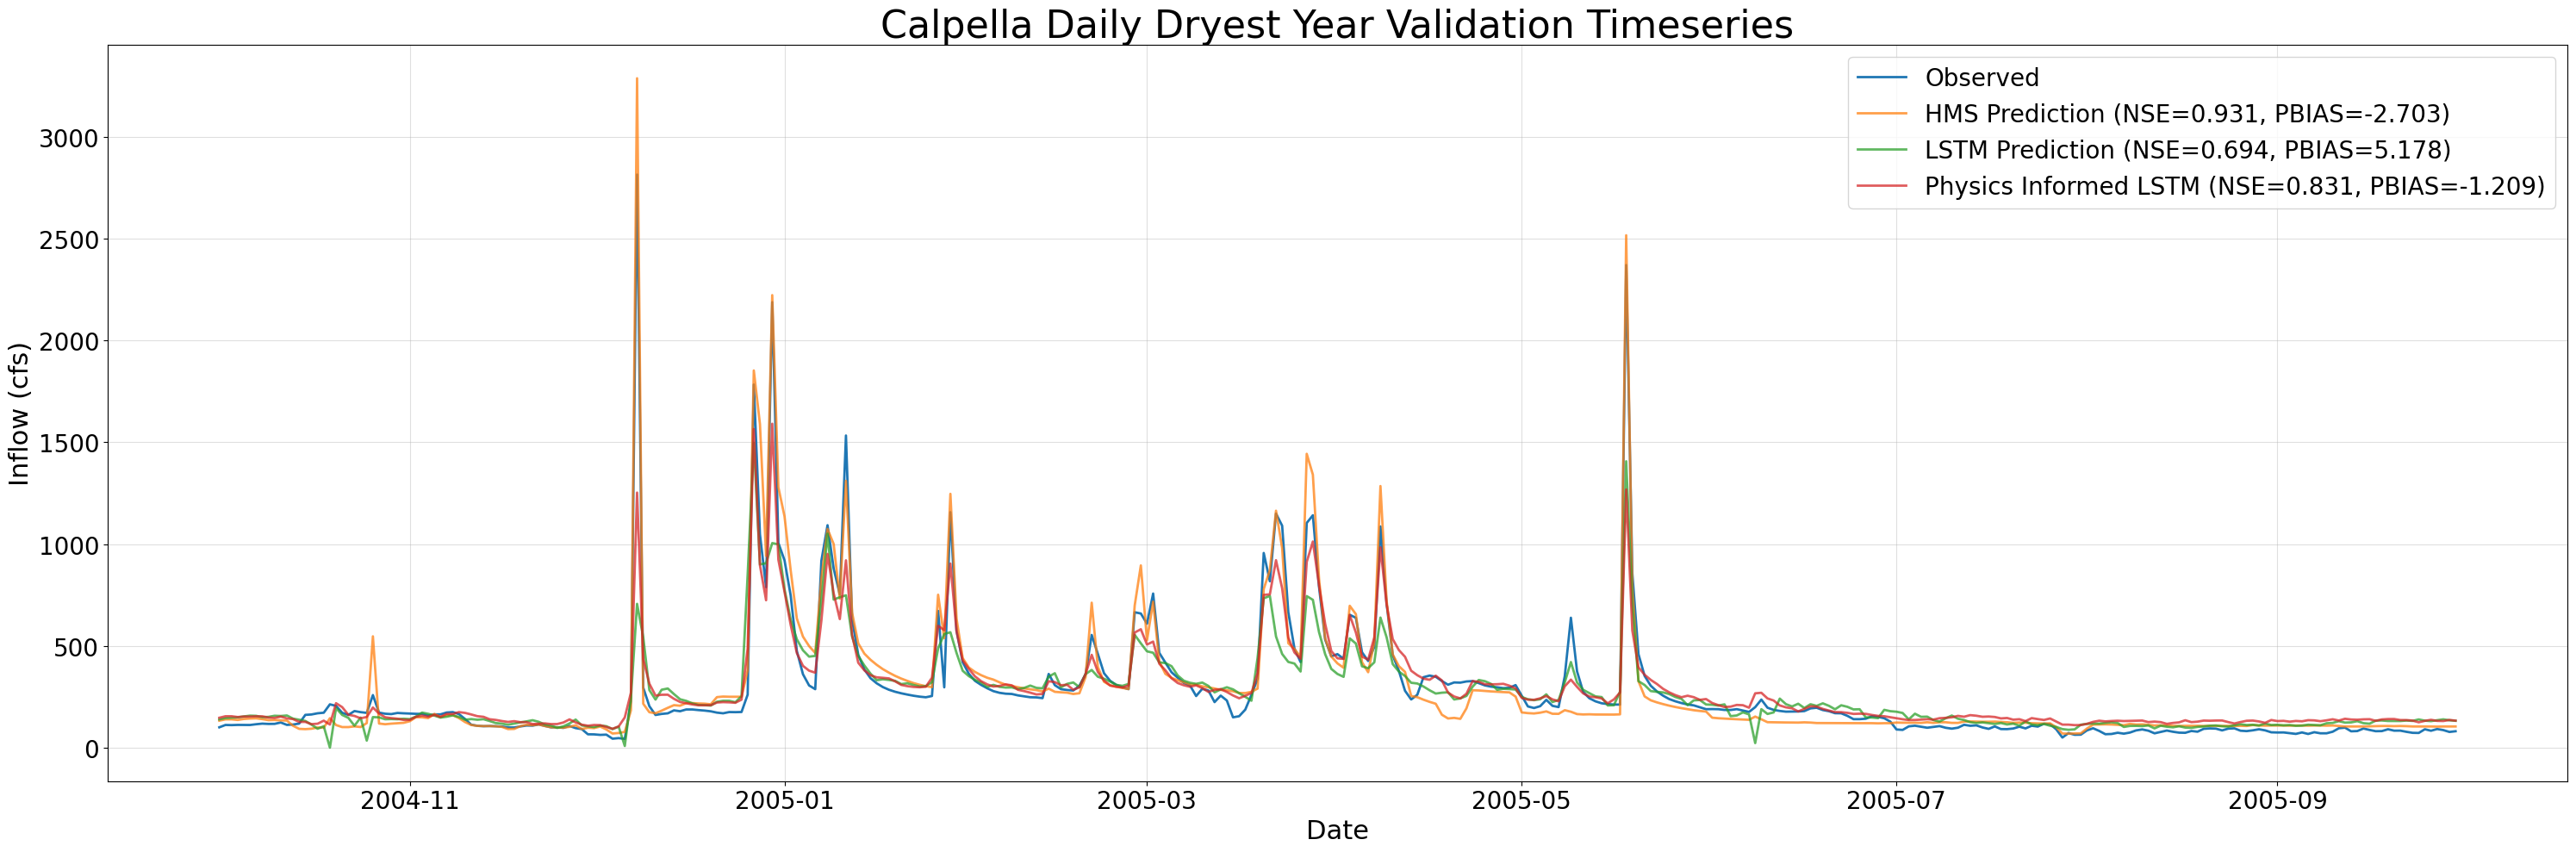

: 

In [ ]:
if not skip_best_model_validation:
    plot_timeseries_comparison(source=(no_physics_val_csv, physics_val_csv, path_to_physics_data), title="Calpella Daily Dryest Year Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="calpella_daily_val_dry_metrics.csv", ts_out="calpella_daily_val_dry_combined_ts.csv", fig_out="calpella_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df_val, title="Calpella Daily Dryest Year Validation Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_val, end_date=dryest_end_val, metrics_out="calpella_daily_val_dry_metrics.csv", ts_out="calpella_daily_val_dry_combined_ts.csv", fig_out="calpella_daily_val_dry_model_comparison.png", legend_font=20, axis_font=22)

HMS
  NSE = -0.339
  PBIAS = -61.317
LSTM
  NSE = 0.613
  PBIAS = -61.586
PILSTM
  NSE = 0.511
  PBIAS = -55.459


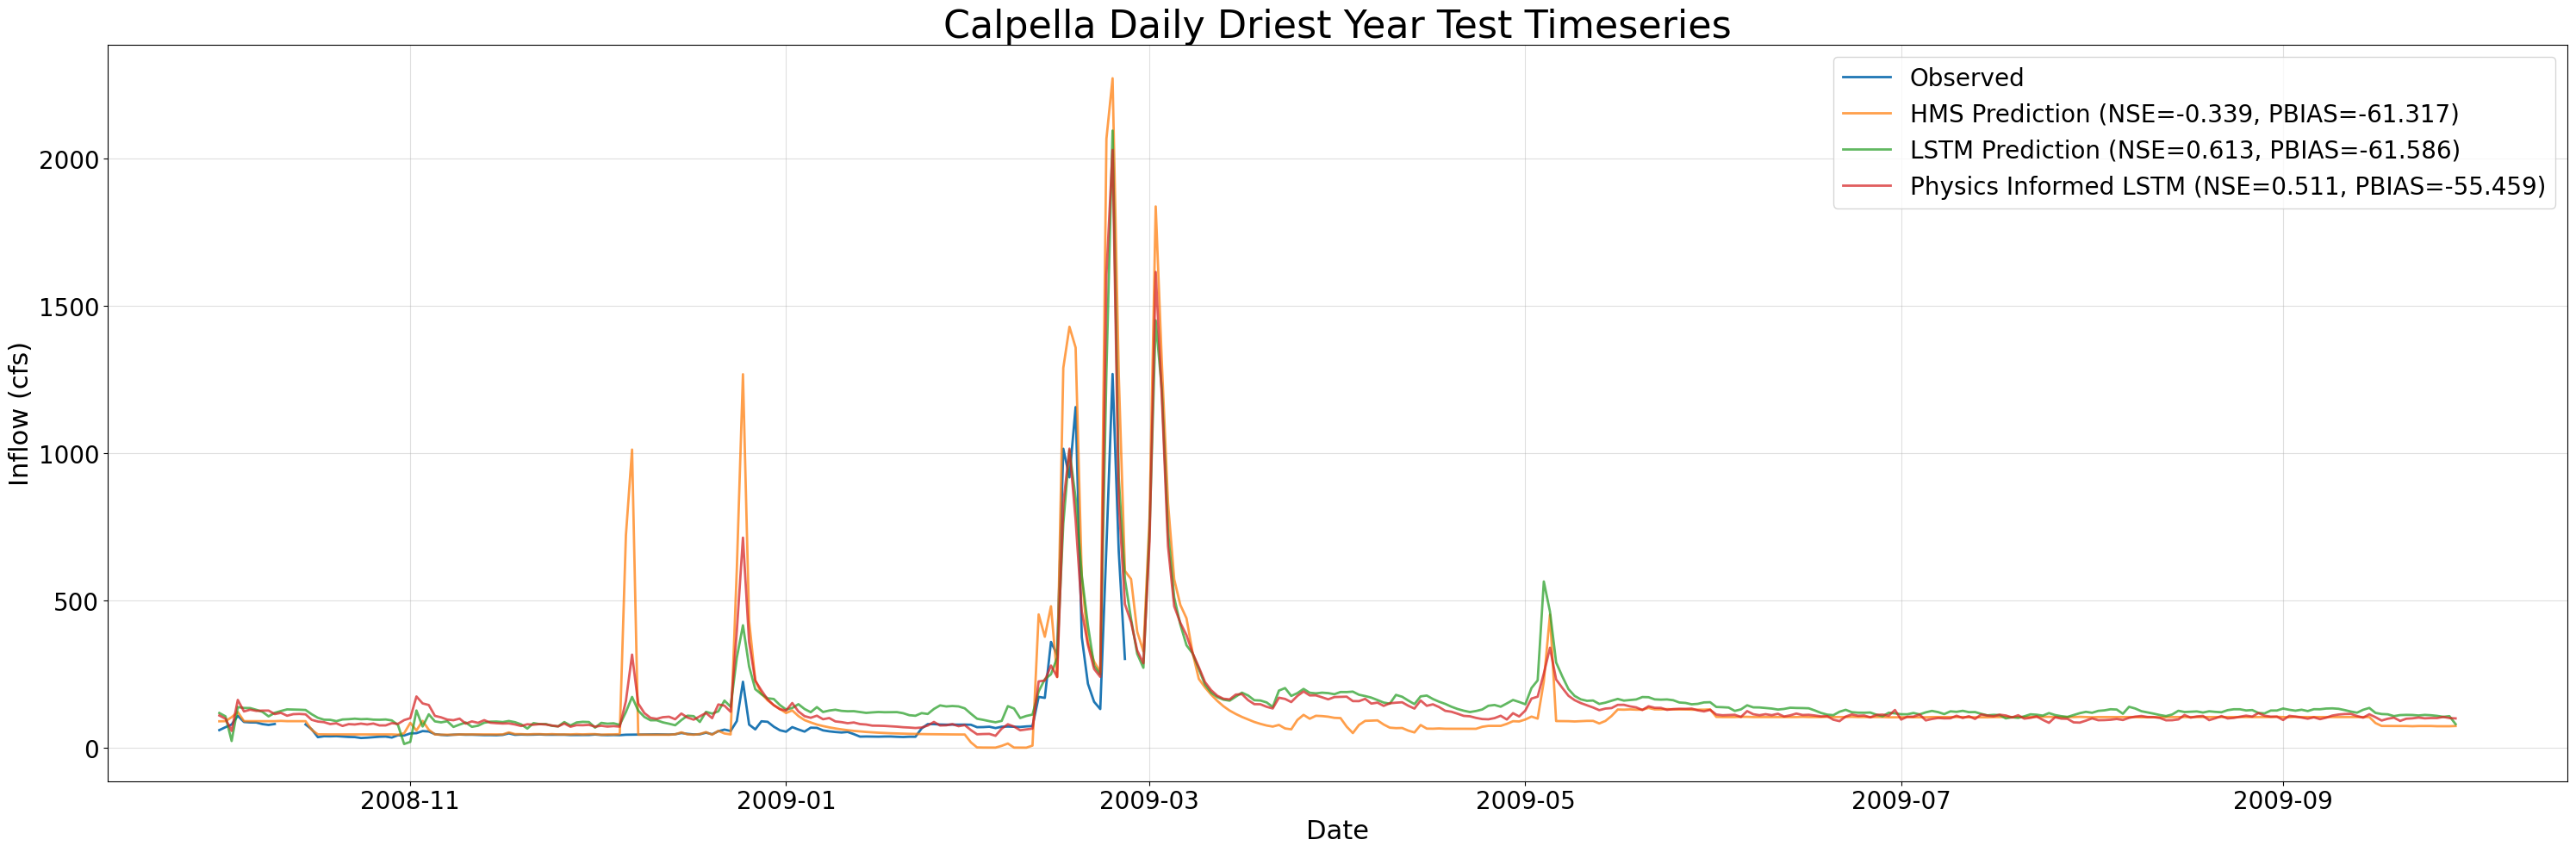

: 

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", fig_out="calpella_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Driest Year Test Timeseries", backend="mpl", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", fig_out="calpella_daily_test_dry_model_comparison.png", legend_font=20, axis_font=22)

In [ ]:
if not skip_best_model_test:
    plot_timeseries_comparison(source=(no_physics_test_csv, physics_test_csv, path_to_physics_data), title="Calpella Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)
else:
    plot_timeseries_comparison(source=combined_df, title="Calpella Daily Driest Year Test Timeseries – Interactive", backend="plotly", metrics=metric_list, start_date=dryest_start_test, end_date=dryest_end_test, metrics_out="calpella_daily_test_dry_metrics.csv", ts_out="calpella_daily_test_dry_combined_ts.csv", legend_font=12, axis_font=22)

HMS
  NSE = -0.339
  PBIAS = -61.317
LSTM
  NSE = 0.613
  PBIAS = -61.586
PILSTM
  NSE = 0.511
  PBIAS = -55.459


: 

##### Gridded Timeseries Plots - Validation and Testing

In [ ]:
if not skip_best_model_validation:
    ts_triptych_v3((no_physics_val_csv, physics_val_csv, path_to_physics_data),wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="calpella_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Calpella Daily Validation Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Validation period","Most-wet water-year","Most-dry water-year"))

else:
    ts_triptych_v3(combined_df_val, wet_start=wettest_start_val, wet_end=wettest_end_val, dry_start=dryest_start_val, dry_end=dryest_end_val, save_path="calpella_daily_TS_validation.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2,main_title = "Calpella Daily Validation Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full validation period", "Most‑wet water‑year", "Most‑dry water‑year"))

: 

In [ ]:
if not skip_best_model_test:
    ts_triptych_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test,dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="calpella_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d-%b-%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title="Calpella Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y=0.99, main_title_pad=0.05, row_titles=("Full Testing period","Most-wet water-year","Most-dry water-year"))

else:
    ts_triptych_v3(combined_df, wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, save_path="calpella_daily_TS_testing.png", legend_font=12, legend_boxpad=0.5, axis_font=12, date_fmt="%d‑%b‑%Y", figsize=(10, 10), dpi=600, hspace=0.2, main_title = "Calpella Daily Test Period Timeseries Across Models", main_title_font=14, main_title_y = 0.99, main_title_pad = 0.05, row_titles=("Full Testing period", "Most‑wet water‑year", "Most‑dry water‑year"))

: 

##### Gridded Scatter Plots - Testing

In [ ]:
if not skip_best_model_test:
    scatter_triptych_pngs_v3((no_physics_test_csv, physics_test_csv, path_to_physics_data), wet_start=wettest_start_test, wet_end=wettest_end_test, dry_start=dryest_start_test, dry_end=dryest_end_test, out_dir="calpella_daily_scatter", layout="horizontal", square_side=4.5, legend_font=16, axis_font=16, point_size=28, top_pad=.90, suptitle_y=1.04, dpi=600, row_titles=("Calpella Daily – Full test period", "Calpella Daily – Wettest water-year", "Calpella Daily – Driest water-year"), resolution="daily")
else:
    scatter_pngs = scatter_triptych_pngs_v3(combined_df, wet_start = wettest_start_test, wet_end = wettest_end_test, dry_start = dryest_start_test,  dry_end = dryest_end_test, out_dir = "calpella_daily_scatter", layout = "horizontal", square_side  = 4.5, legend_font  = 16, axis_font = 16, point_size = 28, top_pad = .90, suptitle_y = 1.04, dpi = 600, row_titles = ("Calpella Daily – Full test period", "Calpella Daily – Wettest water‑year", "Calpella Daily – Driest water‑year"), resolution = "daily")

: 